In [1]:
import sys
import os
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF, Rotator, ROCK_PCA

import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)

# Define local plotting parameters
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set_theme(style="white")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 15})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')
plt.rc('text', usetex=True)


# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
processed_data_folder = 'data/processed/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'
std_file_path = 'standardized_rec_data/'


pca_1 = '1_pca/'
pca_2 = '2_pca_normalized/'
pca_3 = '3_pca_normalized_nmodes/'
pca_4 = '4_lowpass_ pca_normalized/'


# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Dedrafted flux
flux_dedrafted = xr.open_dataset(inDirName+
                                 interim_data_folder+
                                 flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')
flux_dedrafted = flux_dedrafted.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
# catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
# catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})

# Add reconstructed datasets - seed random (can also be set as random_state in PCA implementation within xeofs)

/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/ipykernel_24850/2641425726.py:17: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


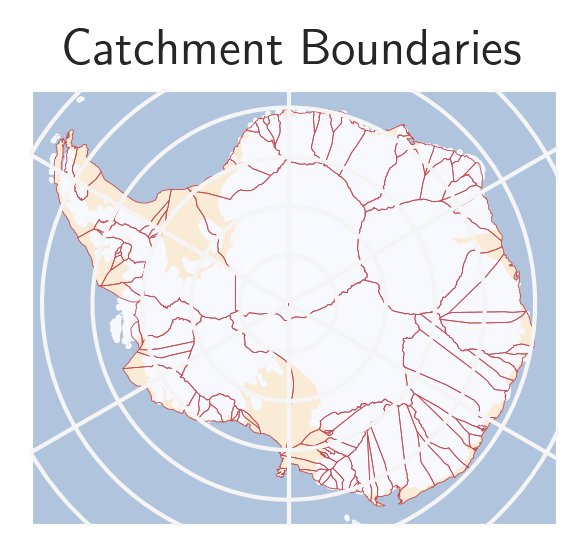

In [2]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [ ]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

flux_clean_demeaned = flux_clean - flux_clean_tmean
# Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

#### EOF Decomposition

There are different solvers included at present, most based on `scikit-learn` decomposition techniques. Implementation is presently clunky. All solvers need to be refactored into a single method (`solve`), and made such that the user can input solver as a parameter when calling the `EOF` class.

`model = EOF(dataset)`

`model.solve()` : The standard PCA solver. This is available out of the box in `xeofs`. 

`model.solveincremental()` : Incremental PCA. Takes additional parameters, defined in the `EOF` methods. `whiten=True` removes important information, and is not recommended (see also `solvesparse` below). Defaults to `whiten=False`.

`model.solvesparse()` : Sparse PCA. Inordinately expensive to compute, also requires additional parameters. `alpha = 1` has already been run, with promising results with the removal of high frequency components at a catchment level. However, the sparsity strength was too high, and overall magnitude of the generator output reduced significantly. `alpha` parameter can be modified to reduce sparsity strength, and might possibly yield improved results. ~12 hours computational time for each run on local machine.

`model.tvsdsolve()` : Truncated SVD. Need to update.

In [ ]:
%%time
model = EOF(flux_clean_normalized) # change accordingly if using original data, or normalized data
model.solvesparseminibatch()
#model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
#varexpl = model.explained_variance_ratio()
#pcs_eig = model.pcs(1)
#pcs_sng = model.pcs(2)

In [ ]:
eofs = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"sparsemini_alpha10/sparse_mini_eofs.nc")
pcs = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"sparsemini_alpha10/sparse_mini_pcs.nc")

eofs.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"sparsemini_alpha10/sparse_mini_eofs.nc")
pcs.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"sparsemini_alpha10/sparse_mini_pcs.nc")

In [ ]:
#eofs = eofs.EOFs
#pcs = pcs.PCs

In [ ]:
nmodes = 1500

In [ ]:
eofs = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/eofs.nc")
pcs = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/pcs.nc")

eofs = eofs.EOFs
pcs = pcs.PCs

In [ ]:
# Figure: Relative power of m EOFs
m = 100
sns.set_theme(style="white")
plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='black')
plt.ylabel('Relative Power (\%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs: {:.2f}%'.format(m, varexpl[:m].sum().values*100));

In [ ]:
nmodes_plot = 3 # Number of modes to plot

sns.set_theme(style="white")
fig=plt.figure(figsize=(15,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2.5])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'Standard Deviation Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 2
t_length = pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        #random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

In [ ]:
nmodes_plot = 4 # Number of modes to plot
nrealizations_to_plot = 2 # to be lesser than absolute total number, defined in the Fourier randomization step

sns.set_theme(style="white")
fig=plt.figure(figsize=(25,20))

gs = GridSpec(nmodes_plot, 2, width_ratios=[4, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0,a1) in enumerate(zip(ax0,ax1)):
    for n_realization in range(0,nrealizations_to_plot):
        a0.plot(new_fl[n_realization,:,i],color='b', linewidth=0.5)
        a1.psd(new_fl[n_realization,:,i],color='b', linewidth=0.5)
    a0.plot(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a1.psd(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a0.plot(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a1.psd(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a0.set_title('PC for EOF mode {}'.format(i+1))
    a1.set_title('PSD for PC mode {}'.format(i+1))
    a1.set_xlabel('')

a0.set_xlabel('Time (months)')
a1.set_xlabel('Frequency')
plt.legend();

In [ ]:
Xrec = pcs @ eofs.T

In [ ]:
Xrec = (Xrec*flux_clean_tstd)+flux_clean_tmean

In [ ]:
%%time
new_fl_xr = xr.DataArray(new_fl[0], dims=pcs.dims, coords = pcs.coords, attrs = pcs.attrs)

sparse_mini_rand = new_fl_xr @ eofs.T


In [ ]:
sparse_mini_rand = sparse_mini_rand.transpose("time","y","x")

In [ ]:
sparse_mini_rand = (sparse_mini_rand*flux_clean_tstd)+flux_clean_tmean
#sparse_mini_rand = (sparse_mini_rand - flux_clean_tmean)/flux_clean_tstd

In [ ]:
sparse_recmini_ts = time_series(sparse_mini_rand)
flux_clean_ts = time_series(flux_clean)

#sparse_rec0_ts = sparse_rec0.mean(['y','x'])
flux_clean_normalized_ts = time_series(flux_clean_normalized)

In [ ]:
sparse_mini_rand.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"sparsemini_alpha10/sparsemini_REC_0.nc")

In [ ]:
Xrecrand = Xrecrand.transpose("time","y","x")

In [ ]:
sparse_rec0 = xr.open_dataset(inDirName+interim_data_folder+
                              cise_file_path+std_file_path+'sparsemini_alpha0.1/sparsemini_REC_0.nc')
sparse_rec0 = sparse_rec0.__xarray_dataarray_variable__
sparse_rec0 = (sparse_rec0-flux_clean_tmean)/flux_clean_tstd
sparse_rec0 = sparse_rec0.transpose("time","y","x")
sparse_rec0 = (sparse_rec0*flux_clean_tstd)+flux_clean_tmean

In [4]:
spca_a3 = xr.open_dataset(inDirName+interim_data_folder+
                              cise_file_path+std_file_path+'spcabatch_a3/spcabatch_a3_REC0.nc')
spca_a10 = xr.open_dataset(inDirName+interim_data_folder+
                              cise_file_path+std_file_path+'spcabatch_a10/spcabatch_a10_REC0.nc')
spca_a3 = spca_a3.__xarray_dataarray_variable__
spca_a10 = spca_a10.__xarray_dataarray_variable__

In [3]:
sparse_rec0 = xr.open_dataset(inDirName+interim_data_folder+
                              cise_file_path+std_file_path+'sparsemini_alpha0.1/sparsemini_REC_0.nc')
sparse_rec0 = sparse_rec0.__xarray_dataarray_variable__

In [ ]:
sparse_rec3_ts = time_series(sparse_rec3)
sparse_rec1_ts = time_series(sparse_rec1)
sparse_rec10_ts = time_series(sparse_rec10)

In [ ]:
sparse_rec0_ts = time_series(sparse_rec0)
#sparse_rec1_ts = time_series(sparse_rec1)
flux_clean_ts = time_series(flux_clean)

#sparse_rec0_ts = sparse_rec0.mean(['y','x'])
#flux_clean_normalized_ts = time_series(flux_clean_normalized)

In [5]:
spca_a01 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a01/spca_a01_REC0.nc")
spca_a01 = spca_a01.__xarray_dataarray_variable__

spca_a1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_a1/spca_a1_REC0.nc")
spca_a1 = spca_a1.__xarray_dataarray_variable__

In [ ]:
spca_rec0_ts = spca_a01.sum(['y','x'])
spca_rec1_ts = spca_a1.sum(['y','x'])
spca_a3_ts = spca_a3.sum(['y','x'])
spca_a10_ts = spca_a10.sum(['y','x'])


In [6]:
flux_clean_ts = flux_clean.sum(['y','x'])

In [ ]:
spca_a01_ts = spca_rec0_ts
spca_a1_ts = spca_rec1_ts

In [3]:
spca_a1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"spca_orig_a1/spca_orig_a1_REC0.nc")
spca_a1 = spca_a1.__xarray_dataarray_variable__

In [4]:
spca_a1_ts = spca_a1.sum(['y','x'])

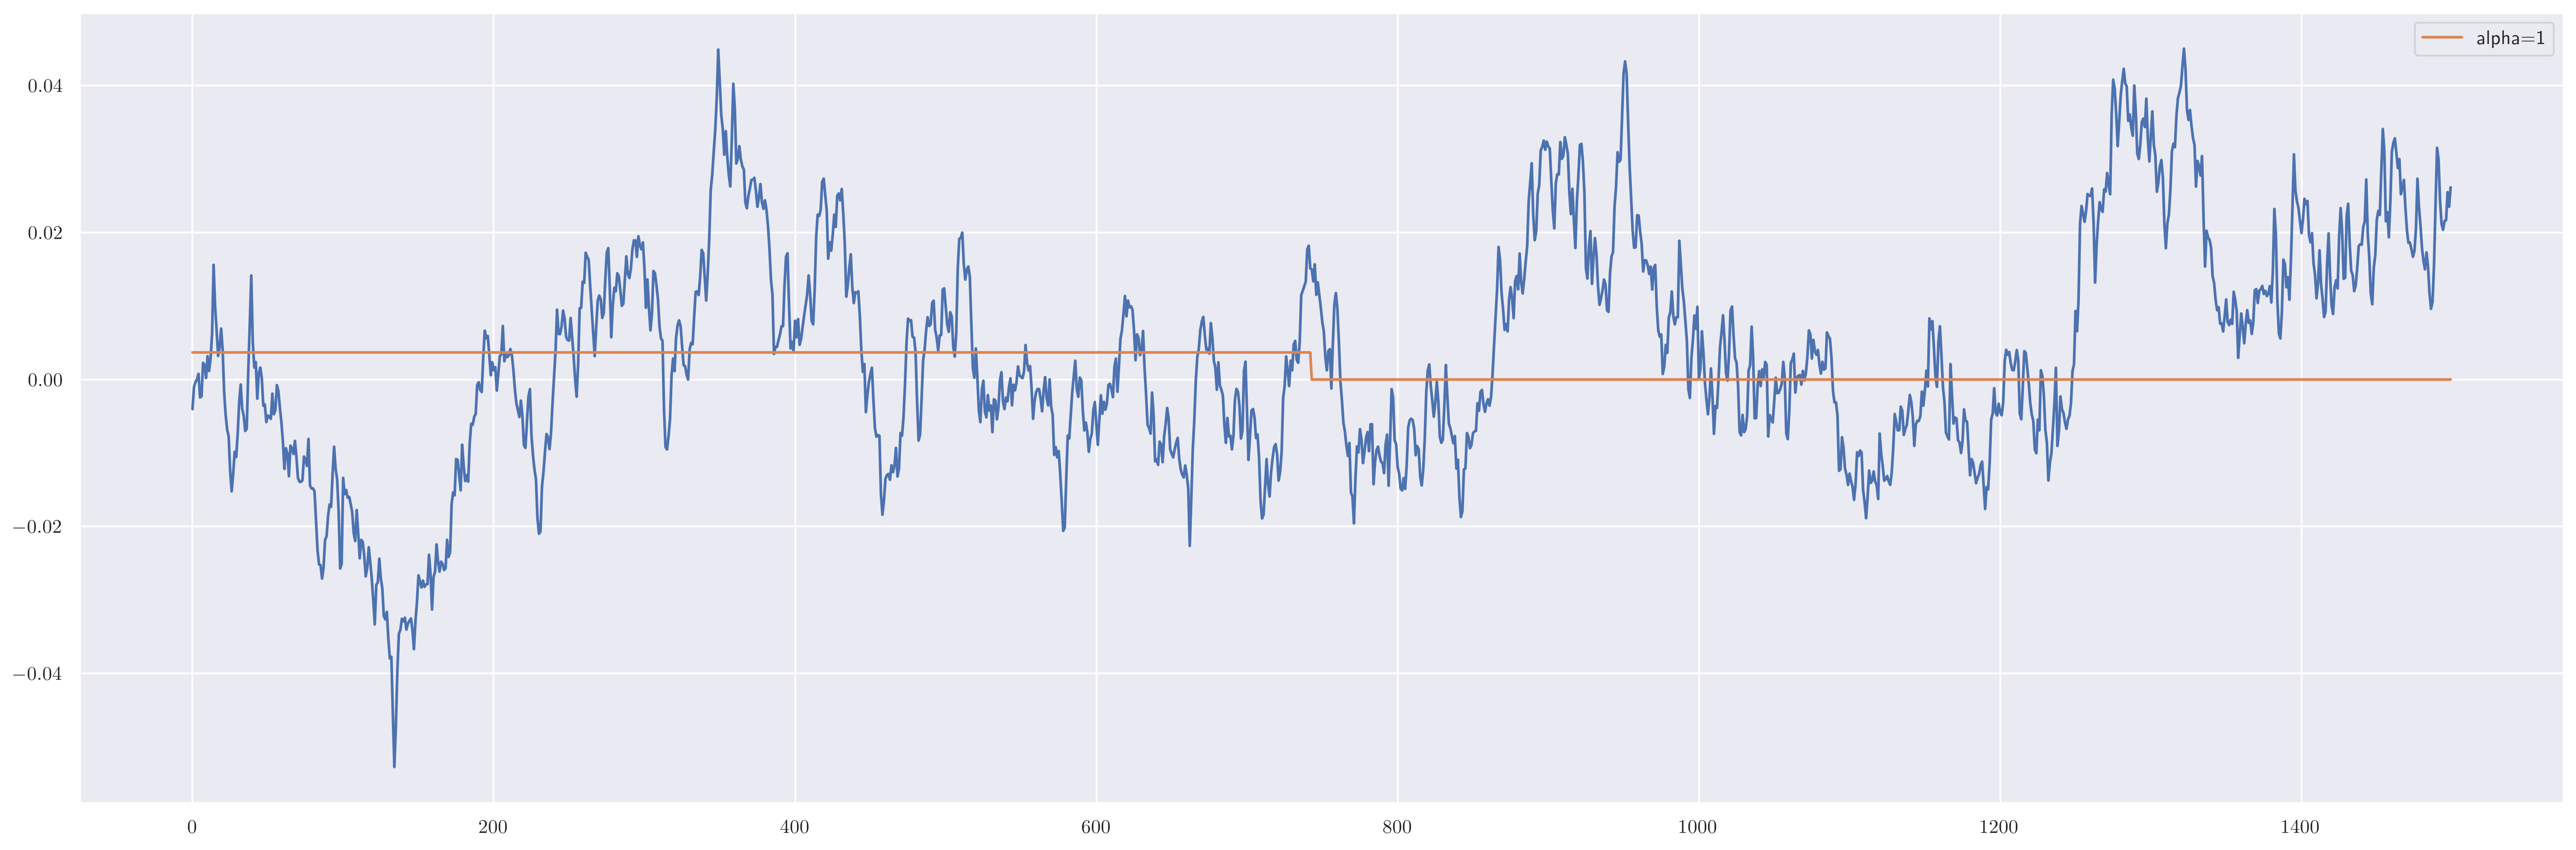

In [7]:
plt.figure(figsize=(25,8))
plt.plot(flux_clean_ts);
plt.plot(spca_a1_ts, label='alpha=1');
#plt.plot(spca_rec1_ts, label='alpha=1');
#plt.plot(sparse_rec3_ts, label='alpha=3');
#plt.plot(sparse_rec10_ts, label='alpha=10');
plt.legend()

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(flux_clean_ts);
plt.plot(spca_rec0_ts, label='alpha=0.1');
plt.plot(spca_rec1_ts, label='alpha=1');
#plt.plot(sparse_rec3_ts, label='alpha=3');
#plt.plot(sparse_rec10_ts, label='alpha=10');
plt.legend()

In [ ]:
plt.figure(figsize=(25,8))
plt.psd(flux_clean_ts);
plt.psd(spca_rec0_ts, label='alpha=0.1');
plt.psd(spca_rec1_ts, label='alpha=1');
#plt.plot(sparse_rec3_ts, label='alpha=3');
#plt.plot(sparse_rec10_ts, label='alpha=10');
plt.legend()

41701

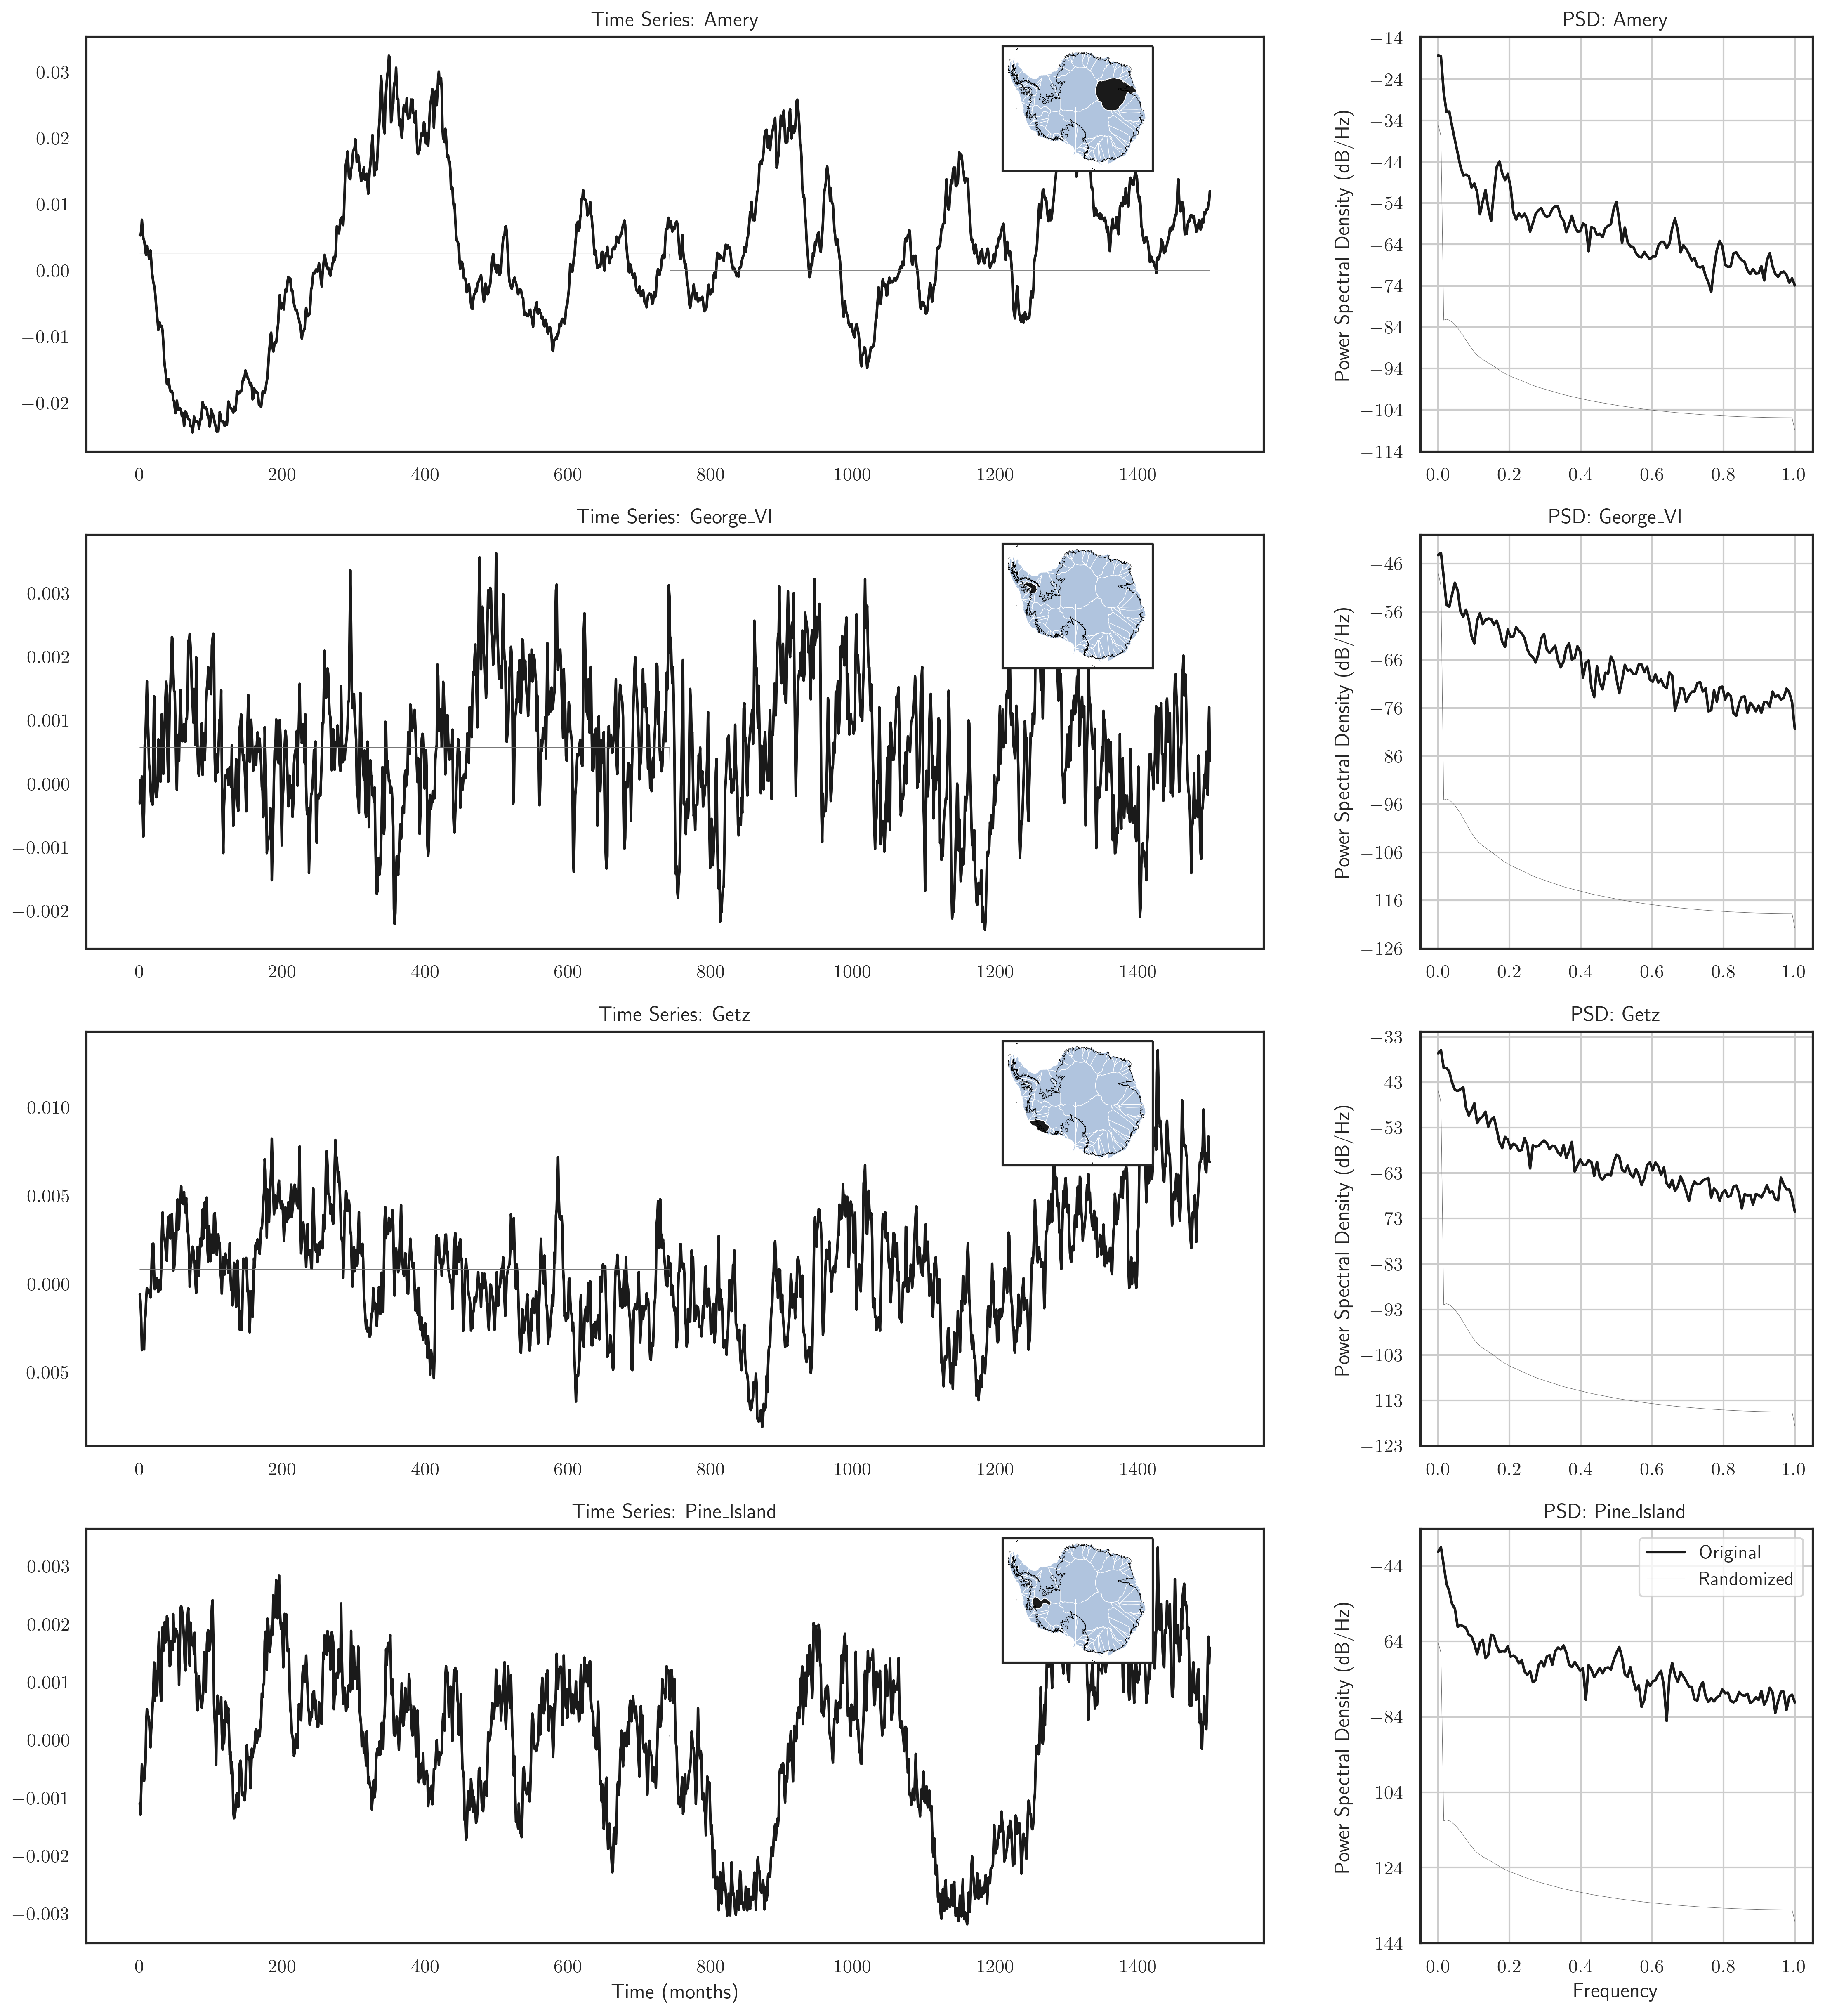

In [11]:
#catchments = np.array([1,27,28,61,70,83])
catchments = np.array([1,27,28,61])
basins = catchments+33
n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[3, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    orig = clip_data(flux_clean, basins[i])
    rec0 = clip_data(spca_a1, basins[i])
    #rec1 = clip_data(sparse_rec1, basins[i])
    #rec2 = clip_data(flux_reconstr2, basins[i])
    orig = orig.rename('orig')
    rec0 = rec0.rename('rec0')
    #rec1 = rec1.rename('rec1')
    #rec2 = rec2.rename('rec2')
    combined = xr.merge([orig,rec0])
    combined_ts = time_series(combined)
    a0.plot(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a0.plot(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    #a0.plot(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a0.plot(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a1.psd(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    #a1.psd(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a1.psd(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a0.set_title('Time Series: {}'.format(icems.name[basins[i]]))
    a1.set_title('PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    a1.set_xlabel('')
    axins = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='k',linewidth=0.4)
    del orig, rec0, combined
a1.legend();
a0.set_xlabel('Time (months)');
a1.set_xlabel('Frequency');
#plt.savefig(inDirName+processed_data_folder+pca_3+'generator-compare_{}-modes'.format(mode_number))
gc.collect()

In [ ]:
plt.figure(figsize=(12,8))
plt.psd(flux_clean_ts);
plt.psd(sparse_rec0_ts, label='alpha=1');
#plt.psd(sparse_rec3_ts, label='alpha=3');
#plt.psd(sparse_rec10_ts, label='alpha=10');
plt.legend()

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(flux_clean_ts);
plt.plot(sparse_rec1_ts, label='alpha=1');
plt.plot(sparse_rec3_ts, label='alpha=3');
plt.plot(sparse_rec10_ts, label='alpha=10');
plt.legend()

In [ ]:
Xrecrand.to_netcdf(inDirName+interim_data_folder+cise_file_path+
                   std_file_path+"truncatedsvd/sparse_REC_0.nc")

In [ ]:
xr.__file__

In [10]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = model.reconstruct_randomized_sparse_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = model.reconstruct_X() #(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

def generate_noise(n_realization,mode,mode_skip):
#flux_reconstr_noise = model.reconstruct_randomized_X(new_fl_high[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr_noise


def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [ ]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(2):
    flux_reconstr = generate_data(i, 1500, 1)
    #flux_reconstr_noise = generate_noise(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    #flux_reconstr_noise = (flux_reconstr_noise*flux_clean_tstd)+flux_clean_tmean
    #flux_reconstr = flux_reconstr + flux_reconstr_noise
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+"randomizedsvd/REC_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

In [ ]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'randomizedsvd/REC_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'randomizedsvd/REC_1.nc')
flux_reconstr1 = flux_reconstr1.__xarray_dataarray_variable__

In [ ]:
# Full AIS data comparisons
flux_clean_ts = time_series(flux_clean)
flux_reconstr0_ts = time_series(flux_reconstr0)
flux_reconstr1_ts = time_series(flux_reconstr1)

In [ ]:
sns.set_theme(style="white")
fig=plt.figure(figsize=(25,8))

plt.plot(flux_clean_ts, color='k', linewidth=1.5,label='Original')
#plt.plot(filtered_flux_ts, color='k', linewidth=1.5,label='Original')
plt.plot(flux_reconstr0_ts, color='b', linewidth=0.25,label='Randomized')
plt.plot(flux_reconstr1_ts, color='b', linewidth=0.25)

In [ ]:
plt.figure(figsize=(12,8))
plt.psd(flux_clean_ts, color='k', lw=2,label='Input data (Actual)');
#plt.psd(flux_filtered_input_reconstruction_ts, color='m',lw=0.5,label='Filter Generator Input')
plt.psd(flux_reconstr0_ts,color='b', lw=1.5,label='Randomized');
plt.psd(flux_reconstr1_ts, color='g',lw=0.5);

In [ ]:
modes_used = [200, 500, 1500]
catchments = np.array([1,27,28,61,70,83])
#catchments = np.array([1,27,28,61])
basins = catchments+33
n_basins = len(basins)
color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[3, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    orig = clip_data(flux_clean, basins[i])
    rec0 = clip_data(flux_reconstr0, basins[i])
    rec1 = clip_data(flux_reconstr1, basins[i])
    #rec2 = clip_data(flux_reconstr2, basins[i])
    orig = orig.rename('orig')
    rec0 = rec0.rename('rec0')
    rec1 = rec1.rename('rec1')
    #rec2 = rec2.rename('rec2')
    combined = xr.merge([orig,rec0,rec1])
    combined_ts = time_series(combined)
    a0.plot(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a0.plot(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a0.plot(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a0.plot(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a1.psd(combined_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a1.psd(combined_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a1.psd(combined_ts.rec1,color=color_gen, linewidth=0.25)
    #a1.psd(combined_ts.rec2,color=color_gen, linewidth=0.25)
    a0.set_title('Time Series: {}'.format(icems.name[basins[i]]))
    a1.set_title('PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    a1.set_xlabel('')
    axins = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='k',linewidth=0.4)
    del orig, rec0, rec1, combined
a1.legend();
a0.set_xlabel('Time (months)');
a1.set_xlabel('Frequency');
#plt.savefig(inDirName+processed_data_folder+pca_3+'generator-compare_{}-modes'.format(mode_number))
gc.collect()